# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Для этого будут использованы данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.


Описание данных

Технологический процесс:
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate - ксантогенат (промотер, или активатор флотации), Sulphate - сульфат (на данном производстве сульфид натрия), Depressant - депрессант (силикат натрия)
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

Параметры этапов:
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

## Подготовка данных

### Изучение данных

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

Ознакомимся с данными.

In [ ]:
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
data_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [ ]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [ ]:
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
data_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [ ]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [ ]:
data_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


In [ ]:
data_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


In [ ]:
data_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


Было изучено три датасета: исходные данные, обучающая выборка и тестовая выборка. Таблица с исходными данными содержит 87 колонок и 19439 строк.

### Проверка расчётов эффективности обогащения

Проверим, правильно ли рассчитана эффективность обогащения. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между нашими расчётами и значением признака.

In [ ]:
C = data_train['rougher.output.concentrate_au'] # доля золота в концентрате после флотации/очистки
F = data_train['rougher.input.feed_au'] # доля золота в сырье/концентрате до флотации/очистки
T = data_train['rougher.output.tail_au'] # доля золота в отвальных хвостах после флотации/очистки

recovery = ((C*(F-T))/(F*(C-T)))*100
recovery

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Length: 14149, dtype: float64

In [ ]:
mae = mean_absolute_error(recovery, data_train['rougher.output.recovery'])
print('Средняя абсолютная ошибка: {:.17f}'.format(mae))

Средняя абсолютная ошибка: 0.00000000000000974


Средняя абсолютная ошибка стремится к нулю. Из этого можно сделать вывод, что значение rougher.output.recovery в данных рассчитано корректно.

### Анализ признаков, недоступных в тестовой выборке

 Проанализируем признаки, недоступные в тестовой выборке.

In [ ]:
data_train.shape, data_test.shape

((14149, 87), (5290, 53))

Количество колонок в обучающей выборке 87, количество колонок в тестовой выборке 53. Проверим, какие данные отстутствуют в тестовой выборке.

In [ ]:
set(data_train.columns) - set(data_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке отсутствуют целевые признаки:    
- rougher.output.recovery - эффективность обогащения чернового концентрата;   
- final.output.recovery - эффективность обогащения финального концентрата.  

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют данные из блоков:   
- output - параметры продукта;
- calculation - расчётные характеристики.    

При формировании признакового пространства для модели учтем данный факт.

### Предобработка данных

Проверим наличие пропусков в датасетах data_train и data_test.

In [ ]:
data_train.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [ ]:
data_test.isna().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

Оба датасета имеют пропуски в данных. Для заполнения пропусков используем интерполяцию, которая реализована в методе interpolate().

In [ ]:
data_train = data_train.interpolate()
data_train.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

In [ ]:
data_test = data_test.interpolate()
data_test.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

Проверим дубликаты в датасетах data_train и data_test.

In [ ]:
data_train.duplicated().sum()

0

In [ ]:
data_test.duplicated().sum()

0

Дубликатов не выявлено.

## Анализ данных

### Изучение концентрации металлов (Au, Ag, Pb) на различных этапах очистки

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [ ]:
# cоздадим датафреймы, которые будем использовать для исследования изменений концентрации металлов
au_concentr = data_train[['rougher.input.feed_au', 'rougher.output.concentrate_au','primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
ag_concentr = data_train[['rougher.input.feed_ag', 'rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]
pb_concentr = data_train[['rougher.input.feed_pb', 'rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]

In [ ]:
# напишем функцию для построения графика изменений концентрации металлов
def concentr(df, name):
    fig = sns.catplot(data=df, height = 7)
    fig.set_axis_labels(name)
    fig.set_xticklabels(['Первоначальная концентрация', 'Флотация', 'Первичная очистка', 'Вторичная очистка'])

Посмотрим на концентрацию золота на различных этапах очистки.

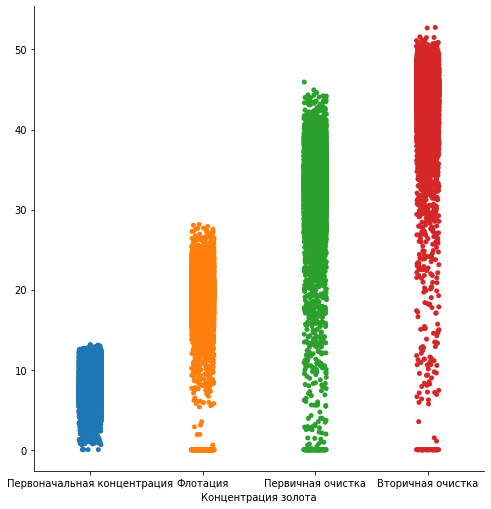

In [ ]:
concentr(au_concentr, 'Концентрация золота')

Концентрация содержания золота повышается по мере очистки и достигает максимальных значений в конце технологического процесса, что полностью соответствует назначению процесса.

Посмотрим на концентрацию серебра на различных этапах очистки.

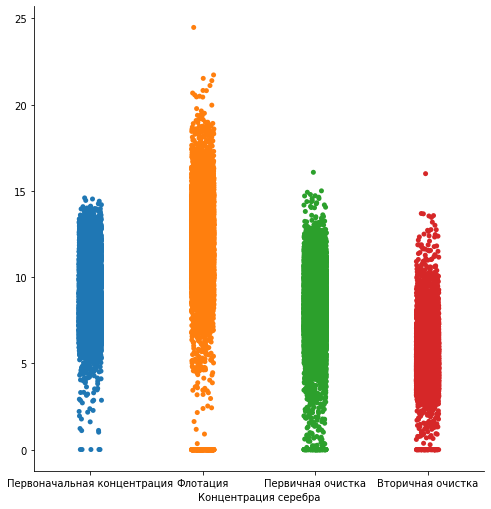

In [ ]:
concentr(ag_concentr, 'Концентрация серебра')

Максимальная концентрация серебра наблюдается на этапе флотации, после чего начинает постепенно снижаться.

Посмотрим на концентрацию свинца на различных этапах очистки.

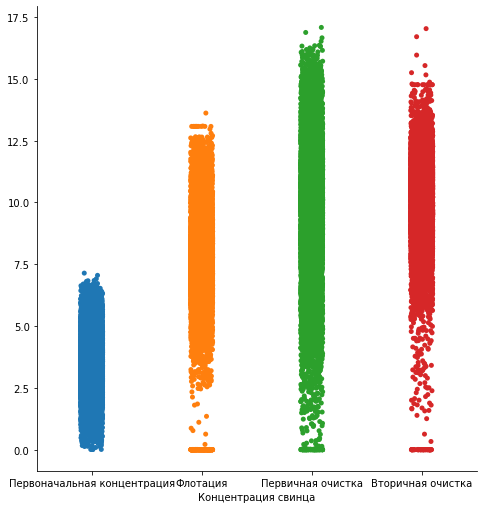

In [ ]:
concentr(pb_concentr, 'Концентрация свинца')

Концентрация свинца постепенно увеличивается, после завершения первичной очистки начинает снижаться.

### Изучение распределения размеров гранул сырья

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

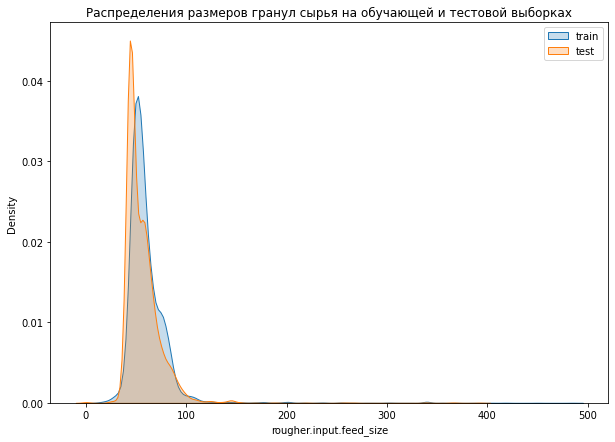

In [ ]:
plt.figure(figsize=(10,7))
sns.kdeplot(data=data_train['rougher.input.feed_size'], label='train', shade=True)
sns.kdeplot(data=data_test['rougher.input.feed_size'], label='test', shade=True)
plt.title('Распределения размеров гранул сырья на обучающей и тестовой выборках')
plt.legend()

График демонстрирует, что распределения размеров гранул сырья отличаются не значительно и соответственно в дальнейшем не повлияют на оценку модели.

### Изучение суммарной концентрации всех веществ

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.    

Посмотрим на концентрацию веществ на стадии сырья.

<AxesSubplot:ylabel='Count'>

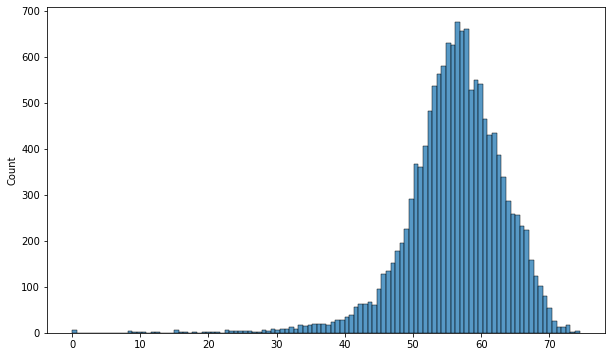

In [ ]:
# концентрация веществ на стадии сырья
total_concentr_rougher_input = data_train['rougher.input.feed_ag'] + data_train['rougher.input.feed_pb'] +\
data_train['rougher.input.feed_sol'] + data_train['rougher.input.feed_au']

fig_dims = (10, 6)
fig1, ax1 = plt.subplots(figsize=fig_dims)
sns.histplot(data=total_concentr_rougher_input)

Посмотрим на концентрацию веществ на стадии чернового концентрата.

<AxesSubplot:ylabel='Count'>

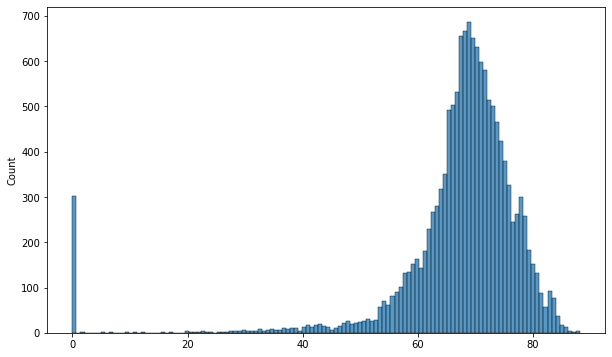

In [ ]:
# концентрация веществ на стадии чернового концентрата
total_concentr_rougher_output = data_train['rougher.output.concentrate_ag'] + data_train['rougher.output.concentrate_pb'] +\
data_train['rougher.output.concentrate_sol'] + data_train['rougher.output.concentrate_au']

fig_dims = (10, 6)
fig1, ax1 = plt.subplots(figsize=fig_dims)
sns.histplot(data=total_concentr_rougher_output)

Посмотрим на концентрацию веществ после первичной очистки.

<AxesSubplot:ylabel='Count'>

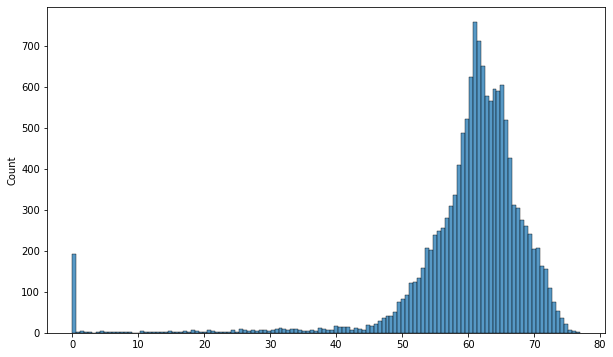

In [ ]:
# концентрация веществ после первичной очистки
total_concentr_primary_cleaner = data_train['primary_cleaner.output.concentrate_ag'] + data_train['primary_cleaner.output.concentrate_pb'] +\
data_train['primary_cleaner.output.concentrate_sol'] + data_train['primary_cleaner.output.concentrate_au']

fig_dims = (10, 6)
fig1, ax1 = plt.subplots(figsize=fig_dims)
sns.histplot(data=total_concentr_primary_cleaner)

Посмотрим на финальную концентрацию веществ после всех этапов очистки.

<AxesSubplot:ylabel='Count'>

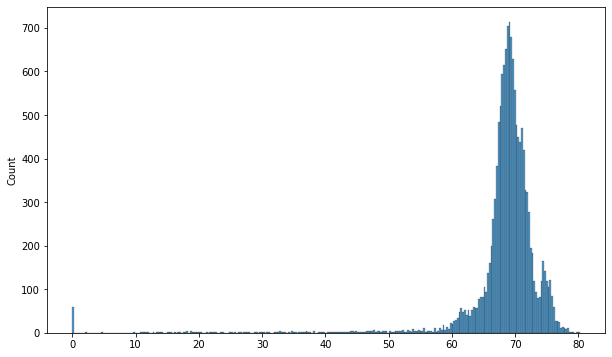

In [ ]:
# финальная концентрация веществ
total_concentr_final_output = data_train['final.output.concentrate_ag'] + data_train['final.output.concentrate_pb'] +\
data_train['final.output.concentrate_sol'] + data_train['final.output.concentrate_au']

fig_dims = (10, 6)
fig1, ax1 = plt.subplots(figsize=fig_dims)
sns.histplot(data=total_concentr_final_output)

Графики продемонстрировали, что присутствует очень много значений суммарной концентрации около 0. Эти данные явно являются выбросами.    

Для обнаружения аномалий используем метод Isolation Forest. Удалим найденные им выбросы.

In [ ]:
train_anomalies = data_train[['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', \
                              'rougher.input.feed_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', \
                              'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', \
                              'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', \
                              'primary_cleaner.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', \
                              'final.output.concentrate_sol', 'final.output.concentrate_au']]

In [ ]:
for_train_model = train_anomalies.columns

isolation_forest = IsolationForest(n_estimators=50, random_state=12345)
isolation_forest.fit(data_train[for_train_model])
predict = isolation_forest.predict(data_train[for_train_model])
data_train['anomalies'] = predict
data_train = data_train.loc[data_train['anomalies']==1]
data_train = data_train.drop(['anomalies'], axis=1)
data_train.reset_index(inplace=True, drop = True)

**Вывод**   
Графики изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки показали:   
- концентрация содержания золота повышается по мере очистки и достигает максимальных значений в конце технологического процесса;    
- максимальная концентрация серебра наблюдается на этапе флотации, после чего начинает постепенно снижаться;    
- концентрация свинца постепенно увеличивается, после завершения первичной очистки начинает снижаться.   

Графики распределения размеров гранул сырья на обучающей и тестовой выборках показали, что распределения размеров гранул сырья отличаются не значительно и соответственно в дальнейшем не повлияют на оценку модели.   

Графики суммарной концентрации всех веществ на разных стадиях (в сырье, в черновом и финальном концентратах) продемонстрировали, что присутствует очень много значений суммарной концентрации около 0. Обнаруженные выбросы были удалены.    

## Модель

### Подготовка обучающей и тестовой выборок

Добавим в тестовую выборку целевые признаки rougher.output.recovery и final.output.recovery из исходных данных. Данные индексируются датой и временем получения информации (признак date), и соседние по времени параметры часто похожи. Установим столбец date в качестве индекса для обоих датасетов, так как данный признак не имеет ценности для дальнейшего обучения модели.

In [ ]:
# установливаем столбец date в качестве индекса
data_full = data_full.set_index('date')
data_test = data_test.set_index('date')

In [ ]:
# добавляем столбцы
columns = ['rougher.output.recovery', 'final.output.recovery']
data_test = data_test.join(data_full[columns])
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5290 non-null   float64
 1   primary_cleaner.input.depressant            5290 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5290 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

Приведем обучающую выборку в соответствие с тестовой, удалив из data_train отсутствующие в data_test колонки.

In [ ]:
data_train = data_train[data_train.columns.intersection(data_test.columns)]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12612 entries, 0 to 12611
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   final.output.recovery                       12612 non-null  float64
 1   primary_cleaner.input.sulfate               12612 non-null  float64
 2   primary_cleaner.input.depressant            12612 non-null  float64
 3   primary_cleaner.input.feed_size             12612 non-null  float64
 4   primary_cleaner.input.xanthate              12612 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      12612 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    12612 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      12612 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    12612 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      12612 non-null  float64
 10  primary_cl

Разделим обучающий и тестовый датасеты на фичи и целевые признаки.

In [ ]:
features_train = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train = data_train[['rougher.output.recovery', 'final.output.recovery']]

features_test = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test = data_test[['rougher.output.recovery', 'final.output.recovery']]

Масштабируем признаки.

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)
pd.options.mode.chained_assignment = None

**Вывод**   
В тестовую выборку из исходных данных были добавлены отсутствующие в ней целевые признаки rougher.output.recovery и final.output.recovery. Также обучающая выборка была приведена в соответствие с тестовой: из data_train были удалены отсутствующие в data_test колонки.    
При помощи метода StandardScaler признаки были масштабированы.

### Функция для вычисления итоговой sMAPE

Напишем функцию для вычисления итоговой sMAPE.

In [ ]:
def smape(x, y):
    x.reset_index(inplace=True, drop = True)
    y = pd.DataFrame(y).reset_index(drop = True)
    smape_rougher = 100/len(x["rougher.output.recovery"]) * np.sum(2 * np.abs(y[0] - x["rougher.output.recovery"]) / (np.abs(x["rougher.output.recovery"]) + np.abs(y[0])))
    smape_final = 100/len(x["final.output.recovery"]) * np.sum(2 * np.abs(y[1] - x["final.output.recovery"]) / (np.abs(x["final.output.recovery"]) + np.abs(y[1])))
    smape = 0.25 * smape_rougher + 0.75 * smape_final
    return smape

In [ ]:
score_smape = make_scorer(smape, greater_is_better=False )

### Обучение моделей

Обучим модель линейной регрессии.

In [ ]:
model = LinearRegression()
lin_reg = cross_val_score(model, features_train, target_train, cv=5, scoring=score_smape)
-lin_reg.mean()

9.382396457981958

Обучим модель дерева принятия решений. Использеум функцию GridSearchCV для подбора оптимальных параметров модели.

In [ ]:
parameters = {'max_depth': [depth for depth in range(1, 20)],
           'min_samples_split': [2, 5, 10],
           'min_samples_leaf': [1, 2, 4]}
dtr = GridSearchCV(DecisionTreeRegressor(random_state=12345),
              param_grid=parameters,
              scoring=score_smape, cv=5, refit=True, n_jobs=-1)
dtr.fit(features_train, target_train)
-dtr.best_score_

8.30607240640313

Обучим модель случайного леса. Используем функцию RandomizedSearchCV для подбора оптимальных параметров модели.

In [ ]:
parameters =  {'n_estimators': [est for est in range(1, 50)],
           'max_depth': [depth for depth in range(1, 20)],
           'min_samples_split': [2, 5, 10],
           'min_samples_leaf': [1, 2, 4]}
rfr = RandomizedSearchCV(RandomForestRegressor(random_state=12345),
              param_distributions=parameters,
              scoring=score_smape, cv=5, refit=True, n_jobs=-1)
rfr.fit(features_train, target_train)
-rfr.best_score_

8.121274013987257

**Вывод**  
Были обучены три модели:  линейная регрессия, модель дерева принятия решений и модель случайного леса. Лучший результат sMAPE показала модель случайного леса.

### Тестирование модели

Лучший результат показала модель случайного леса. Протестируем ее на тестовой выборке.

In [ ]:
predictions_test = rfr.predict(features_test)
print('sMAPE =','{:.4f}'.format(smape(target_test, predictions_test)))

sMAPE = 9.6818


## Вывод

При построении модели, предсказывающей коэффициент восстановления золота из золотосодержащей руды, первоначально были изучены отдельные параметры добычи и очистки.  

Проверка правильности рассчета эффективности обогащения показала, что данное значение рассчитано корректно (средняя абсолютная ошибка стремится к нулю).   

Изучение концентрации металлов (Au, Ag, Pb) на различных этапах очистки показало:   
•	концентрация содержания золота повышается по мере очистки и достигает максимальных значений в конце технологического процесса;   
•	максимальная концентрация серебра наблюдается на этапе флотации, после чего начинает постепенно снижаться;    
•	концентрация свинца постепенно увеличивается, после завершения первичной очистки начинает снижаться.   

Построенные графики распределения размеров гранул сырья на обучающей и тестовой выборках показали, что распределения размеров гранул сырья отличаются не значительно и соответственно в дальнейшем не повлияют на оценку модели.   

Графики суммарной концентрации всех веществ на разных стадиях (в сырье, в черновом и финальном концентратах) продемонстрировали, что присутствует очень много значений суммарной концентрации около 0. Обнаруженные аномалии были удалены.

В тестовую выборку из исходных данных были добавлены отсутствующие в ней целевые признаки rougher.output.recovery и final.output.recovery. Также обучающая выборка была приведена в соответствие с тестовой: из data_train были удалены отсутствующие в data_test колонки.    

Обучены три модели: линейная регрессия, модель дерева принятия решений и модель случайного леса. Для оценки качества моделей была использована метрика sMAPE. Лучший результат оказался у модели случайного леса.   
